In [2]:
"""
Implementation of SVM from scratch and using it for spam filtering on sms dataset and 
visualising it by changing different parameters.

@author: PRIYUSH KUMAR(MIT2020055)
         PANKAJ (MIT2020114)
"""

import numpy as np
import pandas as pd
import math

#Defining different Kernels 

In [3]:
def linear_kernel(power, gamma, coef,**kwargs):
    def f(x1, x2):
        return np.inner(x1, x2)
    return f

def polynomial_kernel(power, gamma, coef, **kwargs):
    def f(x1, x2):
        return (np.inner(x1, x2) + coef)**power
    return f

def rbf_kernel(power, coef, gamma, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)
    return f

def sigmoid_kernel(power, coef, gamma, **kwargs):
    def f(x1, x2):
      alpha= 0.01
      constant= -math.e
      sum=0
      # for i in x1.shape[0]:
        # sum += x1[i] * x2[i]
      a=math.tanh(alpha * sum + constant)
      # return math.tanh(alpha * sum + constant)
      return a
    return f

#Defining Data mainipulation and operation functions

In [4]:
def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy



#SVM model

In [5]:
import cvxopt

cvxopt.solvers.options['show_progress'] = False

class SupportVectorMachine(object):

    def __init__(self, C=1, kernel=linear_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y):

        n_samples, n_features = np.shape(X)
        n = X.shape[0]

        if not self.gamma:
            self.gamma = 1 / n_features

        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])
              
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))

        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
        lagr_mult = np.ravel(minimization['x'])

        idx = lagr_mult > 1e-7
        self.lagr_multipliers = lagr_mult[idx]
        self.support_vectors = X[idx]
        self.support_vector_labels = y[idx]
        self.intercept = self.support_vector_labels[0]

        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []

        for sample in X:
            prediction = 0

            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

In [6]:
def main(X_train, y_train, X_test, y_test,kernel):

      clf = SupportVectorMachine(kernel=kernel)
      clf.fit(X_train,y_train)

      y_train_pred = clf.predict(X_train)

      train_accuracy = accuracy_score(y_train, y_train_pred)
      print ('training Accuracy: {:.4f}'.format(train_accuracy))

      y_test_pred = clf.predict(X_test)

      print("Actual_y_test: ",y_test)
      print("predit_y_test: ",np.array(y_test_pred))
      
      test_accuracy = accuracy_score(y_test, y_test_pred)
      print ('testing Accuracy: {:.4f}'.format(test_accuracy))

      return train_accuracy,test_accuracy

# sms Dataset

In [7]:
sms_data = pd.read_csv("https://raw.githubusercontent.com/PriyushKumar/datasets/main/spam%20ham%20data%20set.csv", encoding='latin-1')
sms_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
sms_data.drop(labels = ['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis = 1,inplace = True)
sms_data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


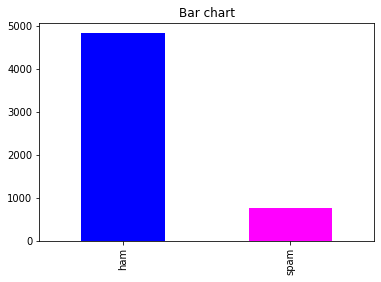

In [9]:
from matplotlib import pyplot as plt
count_Class=pd.value_counts(sms_data["v1"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "magenta"])
plt.title('Bar chart')
plt.show()

#Text analysis

In [ ]:
from collections import Counter
count1 = Counter(" ".join(sms_data[sms_data['v1']=='ham']["v2"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(sms_data[sms_data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

# visualising frequent words in non-spam message

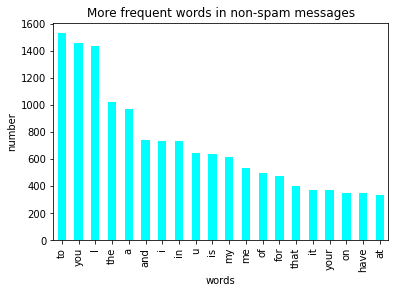

In [ ]:
df1.plot.bar(legend = False,color='cyan')
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

# Visualising frequent word in spam message

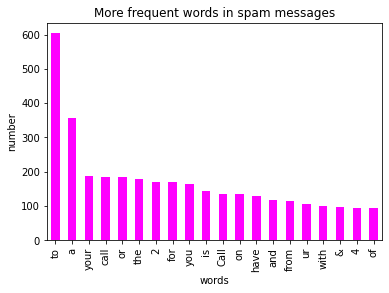

In [ ]:
df2.plot.bar(legend = False, color = 'magenta')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [10]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import feature_extraction,model_selection,metrics

In [11]:
# import nltk
nltk.download('stopwords')
# StopWords = set(stopwords.words('english'))
stemming = PorterStemmer()
corpus = []

for i in range (0,len(sms_data)):
  s1 = re.sub('[^a-zA-Z]',repl = ' ',string = sms_data['v2'][i])
  s1.lower()
  s1 = s1.split()
  s1 = [stemming.stem(word) for word in s1 if word not in set(stopwords.words('english'))]
  s1 = ' '.join(s1)
  corpus.append(s1)

corpus[50]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'what think first time saw class'

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer =CountVectorizer()
x = countvectorizer.fit_transform(corpus).toarray()

In [13]:
print(x)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
sms_data["v1"]=sms_data["v1"].map({'spam':1,'ham':-1})
y = sms_data['v1'].values
print(y)

[-1 -1  1 ... -1 -1 -1]


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, stratify=y,random_state=100)

#Ananlysis accuracy using different kenels

In [15]:
kernel_fn = [linear_kernel,polynomial_kernel,rbf_kernel,sigmoid_kernel]
kernel_name = ['linear kernel','Polynomial kernel','Gaussian RBF kernel','sigmoid_kernel']

In [ ]:
# kernel_fn = [sigmoid_kernel]
SVM_train_accuracy =[]
SVM_test_accuracy =[]

if __name__ == "__main__":
  for i,j in zip(kernel_fn,kernel_name):
    print("#############################")
    print("using ",j)
    print("#############################")
    tr_acc,ts_acc = main(x_train,y_train, x_test, y_test,i)
    SVM_train_accuracy.append(tr_acc)
    SVM_test_accuracy.append(ts_acc)
    print('\n')

#############################
using  linear kernel
#############################
training Accuracy: 0.9992
Actual_y_test:  [-1 -1 -1 ...  1 -1 -1]
predit_y_test:  [-1. -1. -1. ...  1. -1. -1.]
testing Accuracy: 0.9827


#############################
using  Polynomial kernel
#############################
training Accuracy: 0.9985
Actual_y_test:  [-1 -1 -1 ...  1 -1 -1]
predit_y_test:  [-1. -1. -1. ...  1. -1. -1.]
testing Accuracy: 0.9635


#############################
using  Gaussian RBF kernel
#############################
training Accuracy: 0.8659
Actual_y_test:  [-1 -1 -1 ...  1 -1 -1]
predit_y_test:  [-1. -1. -1. ... -1. -1. -1.]
testing Accuracy: 0.8660


#############################
using  sigmoid_kernel
#############################
training Accuracy: 0.8659
Actual_y_test:  [-1 -1 -1 ...  1 -1 -1]
predit_y_test:  [-1. -1. -1. ... -1. -1. -1.]
testing Accuracy: 0.8660




# training accuracy on different kernels

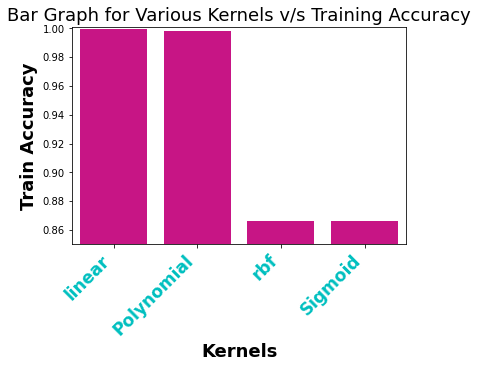

In [ ]:
height = SVM_train_accuracy
bars = ('linear','Polynomial','rbf','Sigmoid')
y_pos = np.arange(len(bars))
plt.axis([-.5, 3.5, 0.85, 1.001 ])

# Basic plot
plt.bar(y_pos, height, color='mediumvioletred')
plt.xlabel('Kernels',fontweight='bold',fontsize=18.0)

plt.ylabel('Train Accuracy',fontweight='bold',fontsize=18.0)
plt.title('Bar Graph for Various Kernels v/s Training Accuracy',fontsize=18.0)

# use the plt.xticks function to custom labels
plt.xticks(y_pos, bars, color='c', rotation=45,
fontweight='bold', fontsize='17', horizontalalignment='right')
plt.show()

# Testing accuracy on different kernels

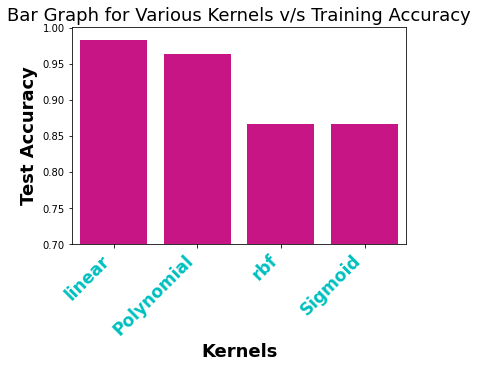

In [ ]:
height = SVM_test_accuracy
bars = ('linear','Polynomial','rbf','Sigmoid')
y_pos = np.arange(len(bars))
plt.axis([-.5, 3.5, 0.7, 1.001 ])

# Basic plot
plt.bar(y_pos, height, color='mediumvioletred')
plt.xlabel('Kernels',fontweight='bold',fontsize=18.0)

plt.ylabel('Test Accuracy',fontweight='bold',fontsize=18.0)
plt.title('Bar Graph for Various Kernels v/s Training Accuracy',fontsize=18.0)

# use the plt.xticks function to custom labels
plt.xticks(y_pos, bars, color='c', rotation=45,
fontweight='bold', fontsize='17', horizontalalignment='right')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, stratify=y,random_state=100)

# Analysing accuracy by changing value of C

In [17]:
list_C = np.arange(500, 700, 100) #100000
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = SupportVectorMachine(C=C)
    svc.fit(X_train, y_train)
    # score_train[count] = svc.score(X_train, y_train)
    y_train_pred = svc.predict(X_train)
    score_train[count] = accuracy_score(y_train, y_train_pred)

    y_test_pred = svc.predict(X_test)
    # score_test[count]= svc.score(X_test, y_test)
    score_test[count]= accuracy_score(y_test, y_test_pred)

    recall_test[count] = metrics.recall_score(y_test, y_test_pred)
    precision_test[count] = metrics.precision_score(y_test, y_test_pred)
    count = count + 1 

In [18]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,1.0,0.980263,0.879464,0.970443
1,600.0,1.0,0.980263,0.879464,0.970443


In [19]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1442,6
Actual 1,27,197


In [20]:
from sklearn.model_selection import train_test_split

#Analysing accuracy by changing size of testing data and training data

In [21]:
test_size=[0.2, 0.3, 0.5, 0.7, 0.8]

testsize_train_accuracy =[]
testsize_test_accuracy =[]

count = 0
for i in test_size:
  X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = i,random_state=100)
  print("#############################")
  print("for test_size = ",i)
  print("#############################")
  tr_acc,ts_acc = main(X_train,y_train, X_test, y_test,kernel=linear_kernel)
  testsize_train_accuracy.append(tr_acc)
  testsize_test_accuracy.append(ts_acc)
  print('\n')

#############################
for test_size =  0.2
#############################
training Accuracy: 0.9991
Actual_y_test:  [-1 -1 -1 ... -1 -1  1]
predit_y_test:  [-1. -1. -1. ... -1. -1.  1.]
testing Accuracy: 0.9883


#############################
for test_size =  0.3
#############################
training Accuracy: 0.9990
Actual_y_test:  [-1 -1 -1 ... -1 -1 -1]
predit_y_test:  [-1. -1. -1. ... -1. -1. -1.]
testing Accuracy: 0.9844


#############################
for test_size =  0.5
#############################
training Accuracy: 0.9989
Actual_y_test:  [-1 -1 -1 ... -1 -1 -1]
predit_y_test:  [-1. -1. -1. ... -1.  1. -1.]
testing Accuracy: 0.9785


#############################
for test_size =  0.7
#############################
training Accuracy: 0.9994
Actual_y_test:  [-1 -1 -1 ... -1 -1 -1]
predit_y_test:  [-1. -1. -1. ... -1. -1. -1.]
testing Accuracy: 0.9780


#############################
for test_size =  0.8
#############################
training Accuracy: 0.7316
Actual_y_test

# training accuracy on different test size

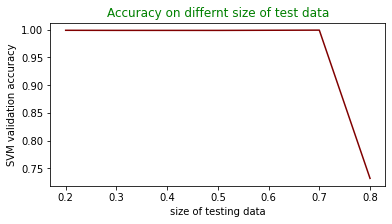

In [22]:
plt.figure(figsize=(6,3))
plt.plot(test_size,testsize_train_accuracy,color='maroon')
plt.xlabel("size of testing data")
plt.ylabel("SVM validation accuracy")
plt.title('Accuracy on differnt size of test data', color = 'g')
plt.show()

# Testing accuracy on different test size

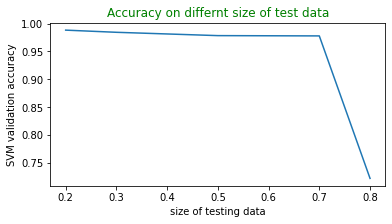

In [23]:
plt.figure(figsize=(6,3))
plt.plot(test_size,testsize_test_accuracy)
plt.xlabel("size of testing data")
plt.ylabel("SVM validation accuracy")
plt.title('Accuracy on differnt size of test data', color = 'g')
plt.show()